In [1]:
import math
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

In [2]:
filepath = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/misc/battery_electricity_consumption.csv')
data = pd.read_csv(filepath)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.weekday
data['date'] = data['timestamp'].dt.normalize()
data['month'] = data['timestamp'].dt.month

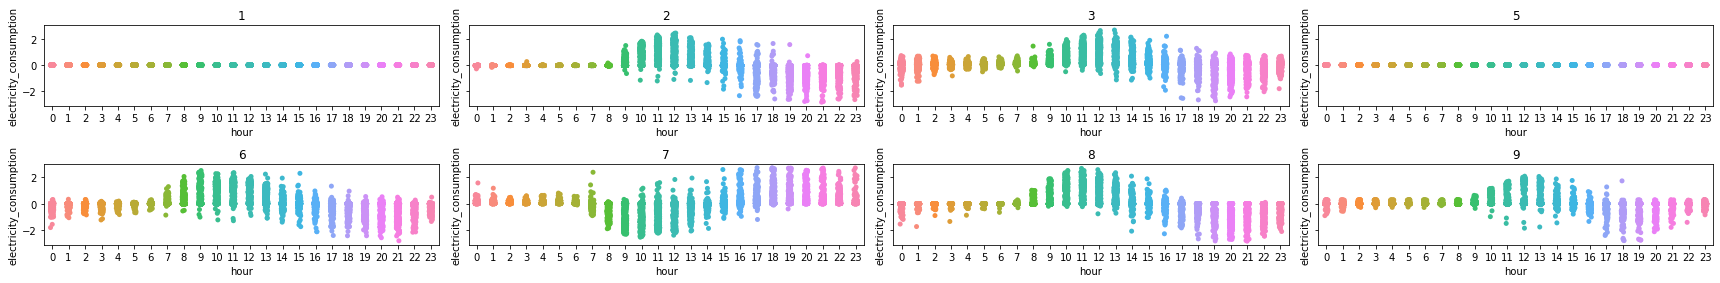

In [4]:
# hourly box plot
column_count_limit = 4
building_count = len(data['citylearn_id'].unique())
row_count = math.ceil(building_count/column_count_limit)
column_count = min(building_count, column_count_limit)
fig, axs = plt.subplots(row_count,column_count,figsize=(6*column_count,2*row_count),sharey=True)

for ax, (building_id, plot_data) in zip(fig.axes,data.groupby('citylearn_id')):
    sns.stripplot(x='hour',y='electricity_consumption',data=plot_data,ax=ax)
    ax.set_title(building_id)

plt.tight_layout()
plt.show()

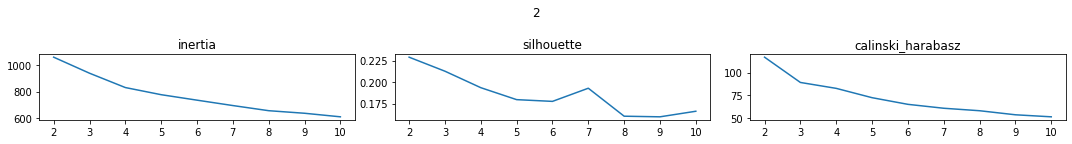

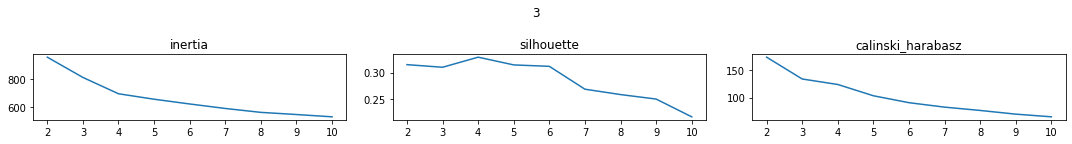

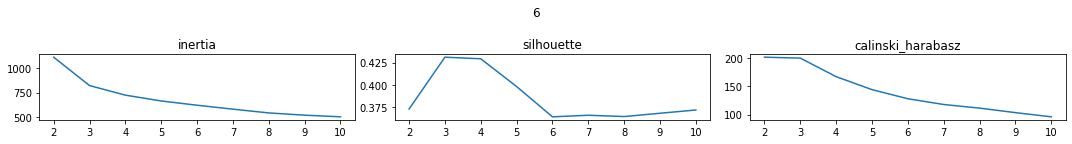

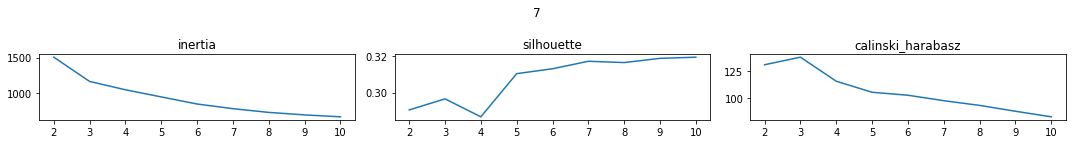

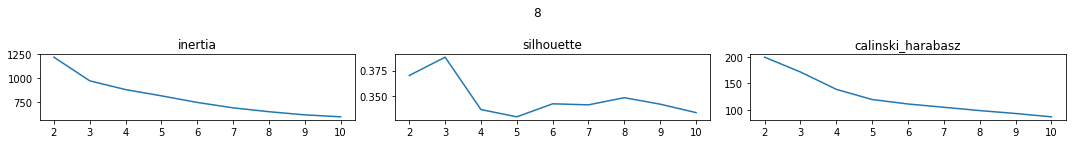

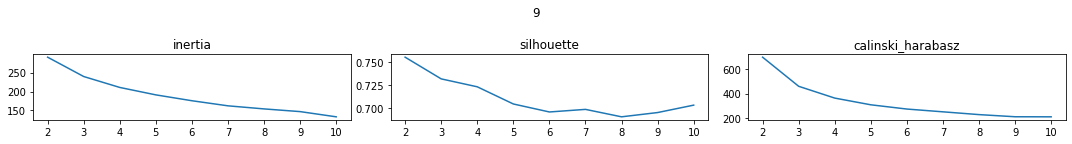

In [26]:
# cluster
building_ids = [2,3,6,7,8,9]
plot_data = data[data['citylearn_id'].isin(building_ids)].copy()
cluster_result = {}
n_clusters_list = list(range(2,11))
random_state = 0

for building_id, cluster_data in plot_data.groupby('citylearn_id'):
    cluster_data = cluster_data.pivot(index='date',columns='hour',values='electricity_consumption')
    x = cluster_data.values
    cluster_result[building_id] = {
        'cluster_data':cluster_data.copy(),
        'n_clusters':n_clusters_list,
        'date':cluster_data.index.tolist(),
        'label':[],
        'score':{
            'inertia':[],
            'silhouette':[],
            'calinski_harabasz':[]
        }
    }
    
    for i, n_clusters in enumerate(n_clusters_list):
        model = KMeans(n_clusters=n_clusters,random_state=random_state).fit(x)
        cluster_result[building_id]['label'].append((model.labels_ + 1).tolist())
        cluster_result[building_id]['score']['inertia'].append(model.inertia_)
        cluster_result[building_id]['score']['silhouette'].append(silhouette_score(x,model.labels_))
        cluster_result[building_id]['score']['calinski_harabasz'].append(calinski_harabasz_score(x,model.labels_))

    row_count = 1
    column_count = 3
    fig, axs = plt.subplots(row_count,column_count,figsize=(5*column_count,2*row_count))

    for ax, (k, v) in zip(fig.axes, cluster_result[building_id]['score'].items()):
        ax.plot(n_clusters_list,v)
        ax.set_title(f'{k}')
        ax.set_xticks(n_clusters_list)

    fig.suptitle(building_id)
    plt.tight_layout()
    plt.show()

In [27]:
cluster_result[3]['cluster_data'].head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2016-08-01,0.096767,0.075400,0.059283,0.058750,0.072000,0.177300,0.151950,0.079033,0.079517,0.184067,...,0.078017,0.061517,0.084667,0.060883,0.062550,0.030317,0.081050,0.061750,0.062267,0.060500
2016-08-02,0.146142,0.011900,0.011783,0.036233,0.012650,0.038900,0.042100,0.031983,0.027467,0.299950,...,-0.303350,-0.101950,-0.535083,-0.467367,-2.654783,0.043717,0.068417,0.205800,0.193433,0.044950
2016-08-03,0.022958,0.024183,0.014417,0.074567,0.014833,0.034500,0.040750,0.020850,0.037217,0.173283,...,-0.399183,0.312250,-1.918400,-2.499233,-0.100700,0.042783,0.097900,0.155233,0.140667,0.067600
2016-08-04,0.104958,0.034050,0.047350,0.082317,0.171983,0.053100,0.050833,0.024950,0.071350,0.316633,...,-0.090300,-0.355667,1.412300,0.700800,0.102983,-1.920733,0.072717,0.129150,0.155400,0.058067
2016-08-05,0.052150,0.062550,0.039017,0.021833,0.047400,0.018517,0.037467,0.037867,0.017417,0.472133,...,-1.011800,0.012417,0.075067,0.139400,0.044333,0.014533,0.085500,0.042900,0.081650,0.010150


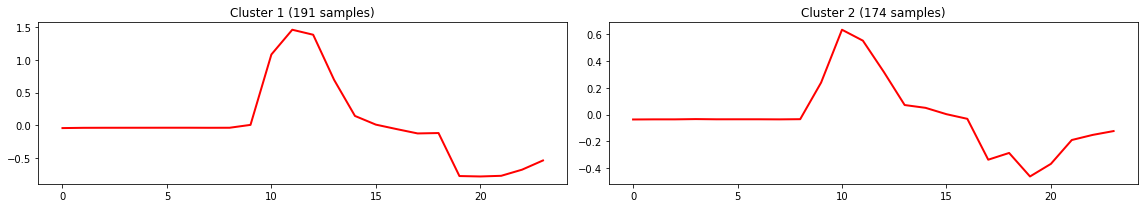

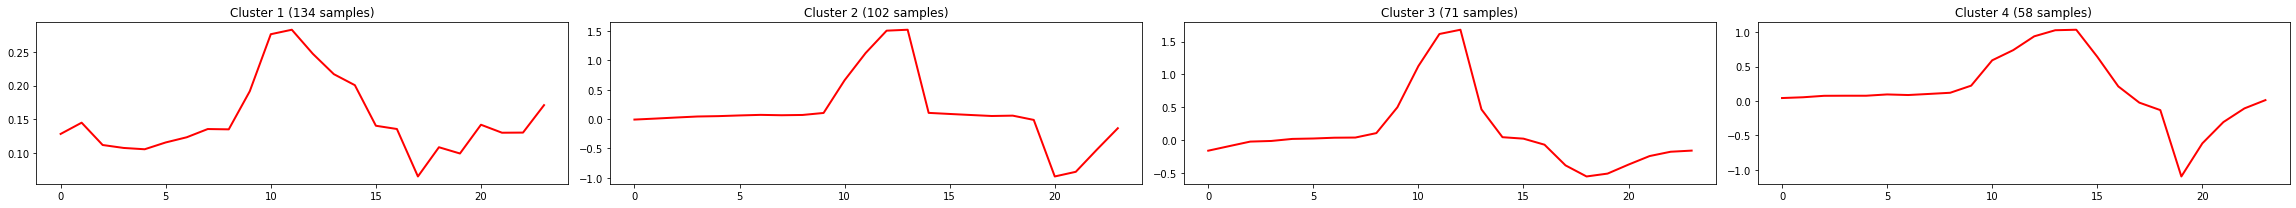

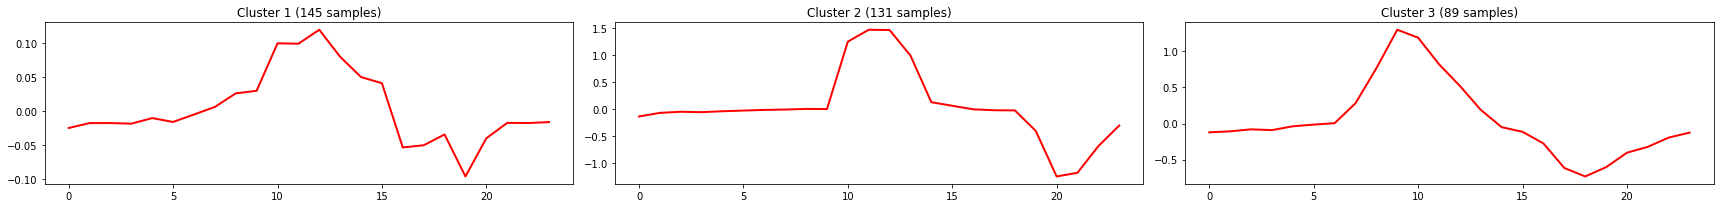

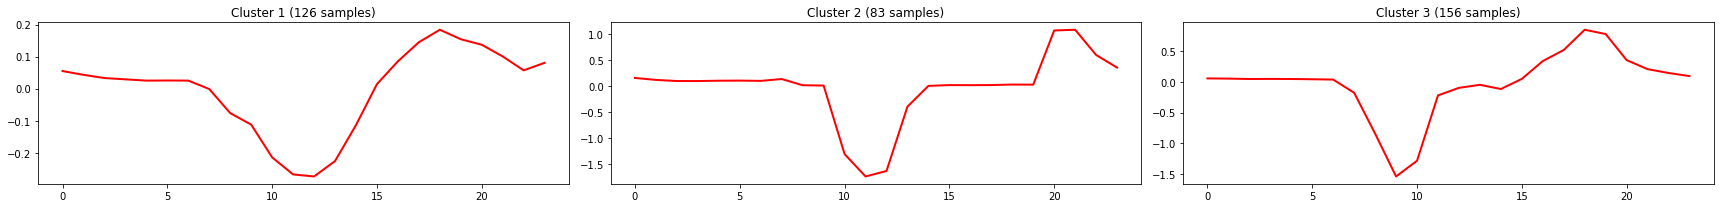

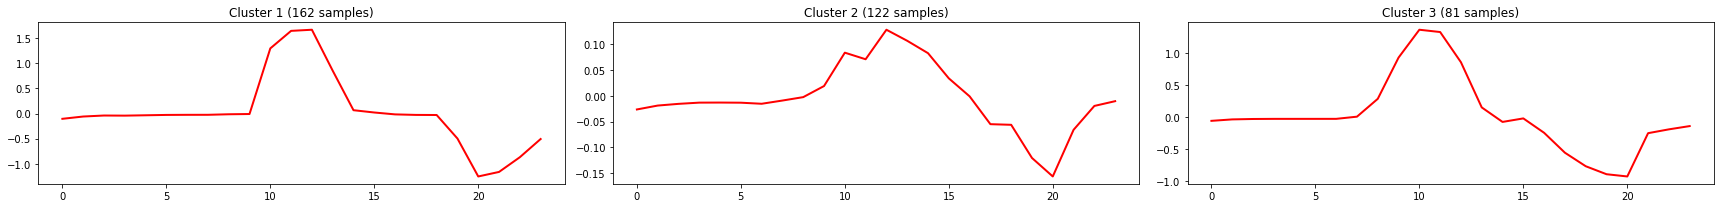

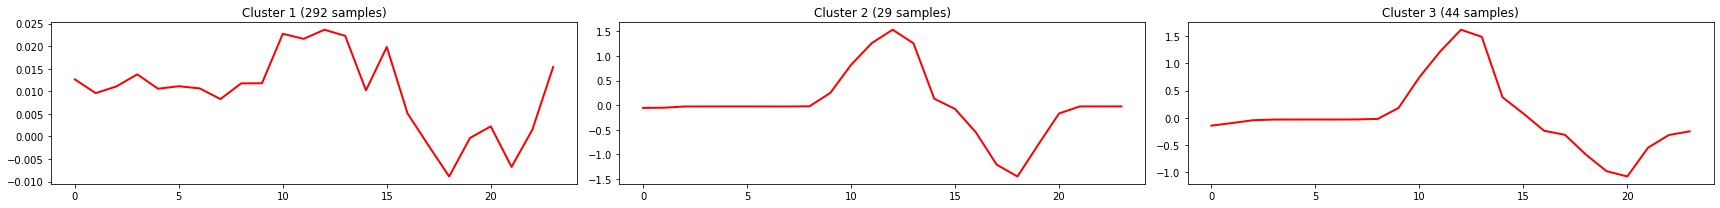

In [29]:
ideal_n_cluster_dict = {2:2,3:4,6:3,7:3,8:3,9:3}

for building_id, ideal_n_clusters in ideal_n_cluster_dict.items():
    ideal_ix = cluster_result[building_id]['n_clusters'].index(ideal_n_clusters)
    cluster_data = cluster_result[building_id]['cluster_data'].copy()
    cluster_data['label'] = cluster_result[building_id]['label'][ideal_ix]

    column_count_limit = 4
    value_columns = list(range(0,24))
    labels = cluster_data['label'].unique()
    row_count = math.ceil(len(labels)/column_count_limit)
    column_count = min(column_count_limit,len(labels))
    fig, axs = plt.subplots(row_count,column_count,figsize=(8*column_count,3*row_count))

    for ax, (label, label_group) in zip(fig.axes,cluster_data.groupby('label')):
        # # samples
        # building_data = label_group.melt(id_vars=['building','date'],value_vars=value_columns,var_name='hour')

        # for building, building_group in building_data.groupby(['building','date']):
        #     x, y = building_group['hour'], building_group['value']
        #     ax.plot(x,y,color='grey',linewidth=0.5)

        # centroid
        x = value_columns
        y = label_group[x].mean(axis=0)
        ax.plot(x,y,color='red',linewidth=2)
        ax.set_title(f'Cluster {label} ({label_group.shape[0]} samples)')
        
    plt.tight_layout()
    plt.show()

In [6]:
from citylearn.utilities import read_json
schema = read_json('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/schema/hyperparameter_design_0.json')
observations = list(schema['observations'].keys())
observations

['month',
 'day_type',
 'hour',
 'daylight_savings_status',
 'outdoor_dry_bulb_temperature',
 'outdoor_dry_bulb_temperature_predicted_6h',
 'outdoor_dry_bulb_temperature_predicted_12h',
 'outdoor_dry_bulb_temperature_predicted_24h',
 'outdoor_relative_humidity',
 'outdoor_relative_humidity_predicted_6h',
 'outdoor_relative_humidity_predicted_12h',
 'outdoor_relative_humidity_predicted_24h',
 'diffuse_solar_irradiance',
 'diffuse_solar_irradiance_predicted_6h',
 'diffuse_solar_irradiance_predicted_12h',
 'diffuse_solar_irradiance_predicted_24h',
 'direct_solar_irradiance',
 'direct_solar_irradiance_predicted_6h',
 'direct_solar_irradiance_predicted_12h',
 'direct_solar_irradiance_predicted_24h',
 'carbon_intensity',
 'indoor_dry_bulb_temperature',
 'average_unmet_cooling_setpoint_difference',
 'indoor_relative_humidity',
 'non_shiftable_load',
 'solar_generation',
 'cooling_storage_soc',
 'heating_storage_soc',
 'dhw_storage_soc',
 'electrical_storage_soc',
 'net_electricity_consumption